In [1]:
import pandas as pd
import cv2
import os
import time, copy

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Data Preparation

## Import Images and Annotations

In [5]:
###load csv file into dataframe
df = pd.read_csv('Annotated_Patches/window_metadata.csv')
df.head()

,ID,Presence
0,B22-101_0.00180,-1
1,B22-101_0.00201,1
2,B22-101_0.00280,-1
3,B22-101_0.00415,-1
4,B22-102_0.01468,1


In [3]:
def preprocess_image(image):
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Isolate the hue channel
    hue_channel = hsv_image[:, :, 0]

    # Normalize the hue channel to be between 0 and 1
    #normalized_hue_channel = hue_channel / 255.0

    # Stack the normalized hue channel with the original image
    preprocessed_image = np.dstack((image, hue_channel))

    return preprocessed_image

In [6]:
#load images and store them along with its corresponding file name

images = {}

#go through the Annotated_Patches folder and open each folder to look for the images
for filename in os.listdir('Annotated_Patches/'):
    
    #if the file is a folder
    if os.path.isdir('Annotated_Patches/' + filename):
        
        #go through the folder and open each image
        for image in os.listdir('Annotated_Patches/'+ filename):
            
            #read the image
            img = cv2.imread('Annotated_Patches/' + filename + '/' + image)
            #to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            #img=preprocess_image(img)
            
            image_name = filename + '.' + image[:-4] #take .png off the image name
            #store the image in the dictionary
            images[image_name] = img

In [7]:
#iterate through the images and store the images in a list along with its corresponding class label from the dataframe
data = []
for name, img in images.items():
    try:
        #get the class label from the dataframe
        label = df.loc[df['ID'] == name]['Presence'].values[0]
        #store the image and its corresponding class label in a list
        data.append([img, label])
    except:
        continue

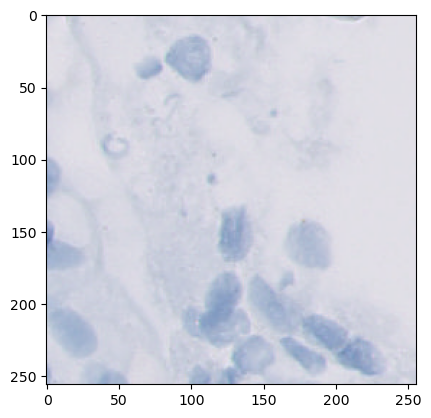

In [9]:
plt.imshow(data[0][0].astype('uint8'))

## Dataset and Dataloaders creation

In [10]:
class Dataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.images = [d[0] for d in data]
        self.labels = [d[1] for d in data]


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        #get the image and its corresponding label
        image = self.images[idx]
        label = self.labels[idx]

        if label == -1:
            label = 0

                
        #convert the image to a tensor
        image = torch.from_numpy(image).float()

        #reshape the image to (1, 3, 256, 256)
        image = image.permute(2, 0, 1)
        image = image.unsqueeze(0)

        #convert the label to a tensor
        label = torch.tensor(label).float()

        return image, label

In [11]:
#augment the data by flipping the images horizontally and vertically
augmented_data = []
for img, label in data:
    augmented_data.append([img, label])
    augmented_data.append([cv2.flip(img, 0), label])
    augmented_data.append([cv2.flip(img, 1), label])

In [12]:
#filter out those images with -1 label
allfiltered_data = [d for d in augmented_data if d[1] == -1]

#filter out those images with 1 label
all_infected_data = [d for d in augmented_data if d[1] == 1]

#balance data
filtered_data = allfiltered_data[:len(all_infected_data)]
infected_data = all_infected_data

print(len(filtered_data), len(infected_data))

489 489


In [209]:
dataset_infected = Dataset(infected_data)
dataset_healthy = Dataset(filtered_data)

#split the data into training and validation set
train_size = int(0.8 * len(dataset_infected))
val_size = len(dataset_infected) - train_size

train_dataset_infected, val_dataset_infected = torch.utils.data.random_split(dataset_infected, [train_size, val_size])

train_size = int(0.8 * len(dataset_healthy))
val_size = len(dataset_healthy) - train_size

train_dataset_healthy, val_dataset_healthy = torch.utils.data.random_split(dataset_healthy, [train_size, val_size])

#combine the infected and healthy training dataset
train_dataset = torch.utils.data.ConcatDataset([train_dataset_infected, train_dataset_healthy])

#combine the infected and healthy validation dataset
val_dataset = torch.utils.data.ConcatDataset([val_dataset_infected, val_dataset_healthy])

#shuffle and batch the training dataset
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)

## Autoencoder

In [16]:
#check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [74]:
# Define a function to compute the red like percentage of an image

def red_percentage(img):
    #convert the image to HSV color space
    hsv = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2HSV)

    #compute the number of pixels with hue in [-20, 20]
    #red_like_pixels = np.sum(np.logical_or((hsv[:, :, 0] < 20) & (hsv[:, :, 0] >= 0), (hsv[:, :, 0] > 160) & (hsv[:, :, 0] <= 180)))
    red_like_pixels = np.maximum(hsv[:, :, 0] < 20, hsv[:, :, 0] > 160).sum()
    
    #compute the percentage of red-like pixels
    red_like_percentage = 100 * (red_like_pixels / (256 * 256))

    return red_like_percentage

### iF new model!

In [233]:

import torchvision.models as models

# Load the pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)
# Modify the last fully connected layer to output 1 class
vgg16.classifier[-1] = nn.Linear(4096, 2)

# Set the model to evaluation mode
vgg16.eval()

# Print the model architecture
print(vgg16)


/Users/pol/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pol/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [234]:
#Function to train our model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()    
    losses = {"train": [], "val": []}   
    final_losses = {"train": [], "val": []} 

    # we will keep a copy of the best weights so far according to validation loss
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0 
            # Iterate over data.
            for window in dataloaders[phase]:
                img = window[0][0]
                label = window[1][0]
                label = label.to(device)
                label = label.long()
                img = img.to(device)               

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss                    
                    output = model(img)
                    #m = nn.LogSoftmax(dim=1)
                    #output = m(output)
                    output = output.squeeze(0)  
                    #output to long
                    
                    loss = criterion(output, label)
                    losses[phase].append(loss.item())                   

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            final_losses[phase].append(epoch_loss)
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, final_losses

In [235]:
# test if the model works with one image
model = vgg16
model.to(device)
#criterion = nn.BCELoss()
#criterion = nn.NLLLoss(reduction="sum")    
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([len(dataset_infected)/len(dataset_healthy)+len(dataset_infected)]).to(device))
#criterion=nn.BCEWithLogitsLoss()
#lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000002)

num_epochs = 35

dataloaders_dict = {}
dataloaders_dict['train'] = train_dataloader
dataloaders_dict['val'] = val_dataloader

In [236]:
for param in model.parameters():
    print(f"Parameter Shape: {param.shape}")
    print(param)

Parameter Shape: torch.Size([64, 3, 3, 3])
Parameter containing:
tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
          [-5.8312e-01,  3.5655e-01,  7.6566e-01],
          [-6.9022e-01, -4.8019e-02,  4.8409e-01]],

         [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
          [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
          [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],

         [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
          [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
          [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],


        [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
          [-4.2805e-01, -2.4349e-01,  2.4628e-01],
          [-2.5066e-01,  1.4177e-01, -5.4864e-03]],

         [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
          [-8.4127e-01, -3.5176e-01,  5.6398e-01],
          [-2.4194e-01,  5.1928e-01,  5.3915e-01]],

         [[-3.1432e-01, -3.7048e-01, -1.3094e-01],
          [-4.7144e-01, -1.5503e-01,  3.4589e-01],
          [ 5.4384e-02,  5.8683e-01,  4.9580e-01]]],


 

In [237]:
#Train the model
model, losses = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/34
----------
train Loss: 1.6240
val Loss: 0.5647
Epoch 1/34
----------
train Loss: 1.1844
val Loss: 0.7026
Epoch 2/34
----------
train Loss: 0.8693
val Loss: 0.5670
Epoch 3/34
----------
train Loss: 0.7868
val Loss: 0.6293
Epoch 4/34
----------
train Loss: 0.6289
val Loss: 0.4661
Epoch 5/34
----------
train Loss: 0.6424
val Loss: 0.4981
Epoch 6/34
----------
train Loss: 0.5373
val Loss: 0.4552
Epoch 7/34
----------
train Loss: 0.5212
val Loss: 0.4264
Epoch 8/34
----------
train Loss: 0.3295
val Loss: 0.6572
Epoch 9/34
----------
train Loss: 0.3735
val Loss: 0.7015
Epoch 10/34
----------
train Loss: 0.3761
val Loss: 0.4546
Epoch 11/34
----------
train Loss: 0.3388
val Loss: 0.3003
Epoch 12/34
----------
train Loss: 0.2288
val Loss: 0.3469
Epoch 13/34
----------
train Loss: 0.2611
val Loss: 0.7375
Epoch 14/34
----------
train Loss: 0.2319
val Loss: 0.2815
Epoch 15/34
----------
train Loss: 0.1607
val Loss: 0.8815
Epoch 16/34
----------
train Loss: 0.1437
val Loss: 0.3265
Epoch 1

In [244]:
torch.save(model.state_dict(), 'Vgg16.pth')

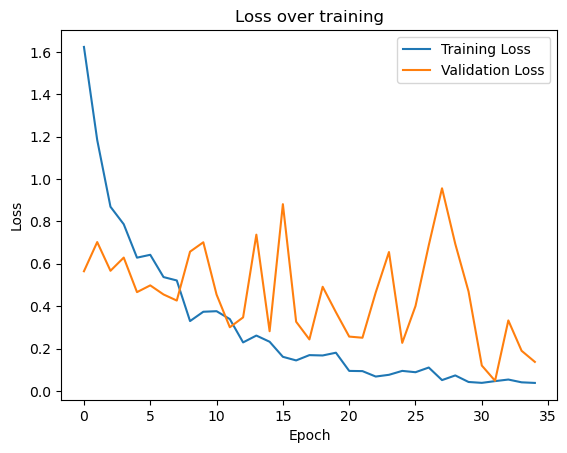

In [239]:
# Extract the loss values and plot them
#We begin at the tenth epoch because the first losses were too big and the scale of the plot was not useful
train_l = losses['train'][:]
val_l = losses['val'][:]
epochs = range(0, len(losses['train'][:]))

# Plot epoch vs training loss until epoch 100
plt.plot(epochs, train_l, label='Training Loss')
plt.plot(epochs, val_l, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over training')
plt.legend()
plt.show()

### Test on Infected Samples

In [240]:
#define a test function with the infected images

predicted_labels = []

for window in val_dataset:
    img = window[0]
    img = img.to(device)
    #feed the image to the model
    output = model(img)
    predicted_label = output.squeeze()

    predicted_label = torch.sigmoid(predicted_label)
   
    #convert the predicted label to numpy
    predicted_label = predicted_label.cpu().detach().numpy()

    #The predicted label is the index of the maximum value in the predicted_label array
    predicted_label = np.argmax(predicted_label)
    predicted_labels.append(predicted_label)


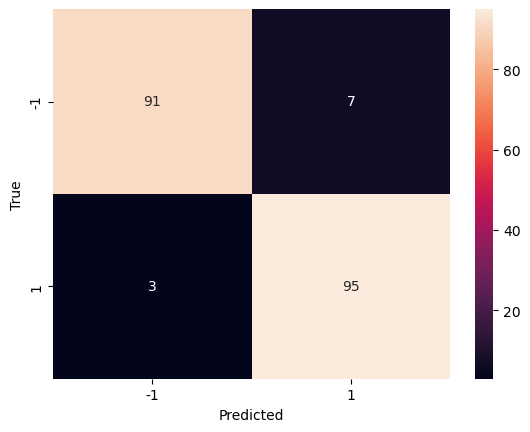

,Precision,Recall,F1,Accuracy
VGG16,0.931373,0.969388,0.95,0.94898


In [241]:
y_true = [d[1] for d in val_dataset]
y_pred = predicted_labels

#compute precision, F1 and recall
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

#compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

#plot confusion matrix
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['-1', '1'], yticklabels=['-1', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#show precision, recall, f1 and accuracy in a table
metrics = {'Precision': [precision], 'Recall': [recall], 'F1': [f1], 'Accuracy': [accuracy]}
metrics_table = pd.DataFrame(data=metrics)
metrics_table.index = ['VGG16']
metrics_table.head()